In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

from MEM_class import MEM

from synthData_Gen import SyntheticData_Gen

Generate a time series of synthetic data through an AR1 process:

In [2]:
s1_instance = SyntheticData_Gen(AR1_coef = 0.3, AR1_var = 120, AR1_dt = 0.001, AR1_N = 20000, diff_len=0.08, dt_sample = 0.025, meas_noise = 0.07)
s1 = s1_instance()

Plot said time series, both raw AR1 process and sampled/diffused series.

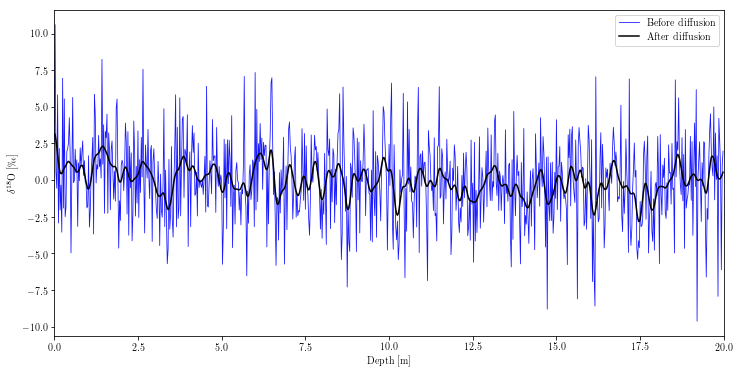

In [3]:
plotFig = True
if plotFig:
    figSynth, axSynth = plt.subplots(figsize=(12,6))
    axSynth.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
    axSynth.plot(s1[2],s1[3],linewidth=0.8, color='blue', alpha=0.9,label='Before diffusion')
    axSynth.plot(s1[4],s1[5], color='black', label='After diffusion')
    axSynth.legend()
    figSynth.savefig('SynthData.png')

Plot only the sampled/diffused data.

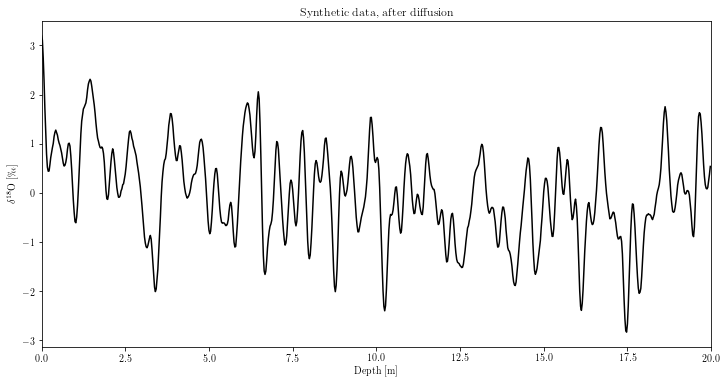

In [4]:
if plotFig:
    figSynthDiff, axSynthDiff = plt.subplots(figsize=(12,6))
    axSynthDiff.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]', title='Synthetic data, after diffusion')
    axSynthDiff.plot(s1[4],s1[5], color='black')


Define depth and signal data from synthetic data. Create an instance of a signal to use for spectral analysis.

In [5]:
depth = s1[4]
data = s1[5]
dt = depth[1] - depth[0]

from SpectralAnalysis import SignalToF

psdType_in = 'FFT'
s_inst = SignalToF(t = depth, y = data, psdType = psdType_in)

Generate a PSD for the signal (given the PSD type wanted {'FFT', 'MEM'}).

Compute the optimal filter through a fit to the PSD data. 

Use fit params to create signal and noise data.

Plot PSD data, fit, signal and noise.

Print out estimate of diffusion length.

Using default boundaries for variance and a1
Diff. len., fit [cm]: 6.768


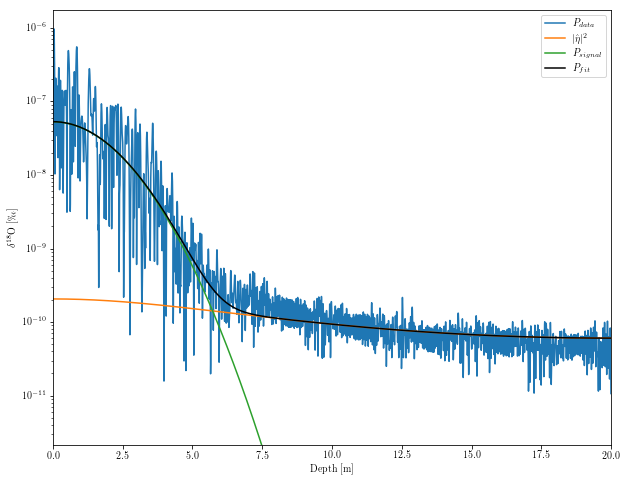

In [6]:
def func_Noise(w, s_eta2, a1, dz):
    return (s_eta2**2 * dz) / (np.abs(1 - a1 * np.exp(- 2 * np.pi * 1j * w * dz))**2)

def func_Signal(w, p0, s_tot2):
    return p0 * np.exp(- (2 * np.pi * w * s_tot2)**2)

if psdType_in == 'FFT':
    PSD = s_inst.fft_psd(N=8192)
elif psdType_in == 'MEM':
    PSD = s_inst.mem(M=40,N=8192)
w_PSD = PSD[0]
P_PSD = PSD[1]


optFit = s_inst.OptFilterFit()
P_Fit = optFit[1]

Pnoise = func_Noise(w_PSD, optFit[0]['s_eta2_fit'],optFit[0]['a1_fit'], dt)
Psignal = func_Signal(w_PSD, optFit[0]['P0_fit'], optFit[0]['s_tot2_fit'])

plotFig = True
if plotFig == True:
    figPSDfit, axPSDfit = plt.subplots(figsize=(10,8))
    axPSDfit.set(ylim=(min(P_PSD)-min(P_PSD)*0.8, max(P_PSD)+max(P_PSD)*0.8), xlim=(min(w_PSD), max(w_PSD)),\
                ylabel='$\delta^{18}$O [\permil]', xlabel='Depth [m]')
    axPSDfit.semilogy(w_PSD, P_PSD, label='$P_{data}$')
    axPSDfit.semilogy(w_PSD, Pnoise, label='$|\hat{\eta}|^2$')
    axPSDfit.semilogy(w_PSD, Psignal, label='$P_{signal}$')
    axPSDfit.semilogy(w_PSD, P_Fit, color='k', label='$P_{fit}$')
   # if psdType_in == 'FFT':
   #     axMEMfit.semilogy(w_PSD, P_Fit, color='k', label='$P_{fit}$')
   # elif psdType_in == 'MEM': 
   #     axMEMfit.semilogy(w_PSD, P_Fit[:-1], color='k', label='$P_{fit}$')
    axPSDfit.legend()
    #figPSDfit.savefig('FFT_PSD_fit.png')
s_eta2_fit = optFit[0]['s_eta2_fit']
s_tot2_fit = optFit[0]['s_tot2_fit']
#print(f'\nVariance, fit: {s_eta2_fit:.3f}')
print(f'Diff. len., fit [cm]: {s_tot2_fit*100:.3f}')

Deconvolve the signal

In [7]:
w, F, T, R, Fsig, Fnoi, dEst = s_inst.convolve()

Using default boundaries for variance and a1


Plot the estimate of the optimal filter, transfer fct., inverse of transfer fct. and restoration filter in a loglog plot.

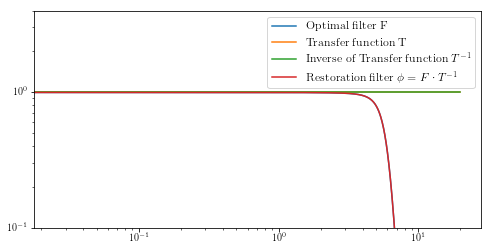

In [8]:
figFilt, axFilt = plt.subplots(figsize=(8,4))
axFilt.loglog(w,F, label='Optimal filter F')
axFilt.loglog(w,T, label='Transfer function T')
axFilt.loglog(w,T**(-1), label = 'Inverse of Transfer function $T^{-1}$')
axFilt.loglog(w,R, label='Restoration filter $\phi = F \cdot T^{-1}$')
axFilt.set(ylim=(0.1,4))#, xlim=(0.01, 7.5))
axFilt.legend(fontsize=12)

Plot the estimate of the optimal filter, transfer fct., inverse of transfer fct. and restoration filter.

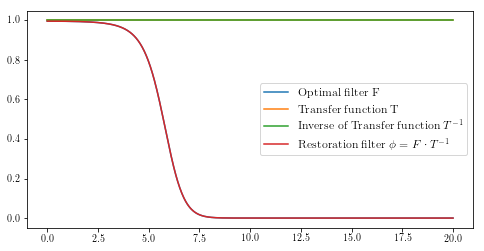

In [9]:
figFilt, axFilt = plt.subplots(figsize=(8,4))
axFilt.plot(w,F, label='Optimal filter F')
axFilt.plot(w,T, label='Transfer function T')
axFilt.plot(w,T**(-1), label = 'Inverse of Transfer function $T^{-1}$')
axFilt.plot(w,R, label='Restoration filter $\phi = F \cdot T^{-1}$')

#axFilt.set(ylim=(0.1,4))#, xlim=(0.01, 7.5))
axFilt.legend(fontsize=12)

Plot the diffused and estimated deconvolved data together.

/home/thea/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


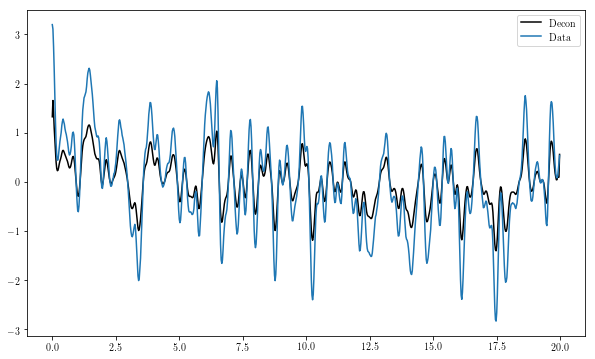

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(depth,dEst,'k', label='Decon')
ax.plot(depth,data, label='Data')
ax.legend()

In [11]:


class StepModel(object):
    """

    """

    def __init__(self):
        """

        """
        return



    def scaled_cdf(self, x, a, b, mu, sigma):
        """
        Returns a scaled and shifted version of the normal cdf
        """

        return [a*sp.stats.norm.cdf(x, loc = mu, scale = sigma) + b, \
        sp.stats.norm.pdf(x, loc = mu, scale = sigma)]



    def scaled_lognormcdf(self, x, a, b, mu, sigma):
        """
        Returns a scaled and shifted version of the lognormal cdf
        """
        return a*sp.stats.lognorm.cdf(x, 1, loc = mu, scale = sigma) + b,\
        a*sp.stats.lognorm.pdf(x, 1, loc = mu, scale = sigma) + b



    def log_product(self, x, a, b, mu, shape1, shape2, sigma1, sigma2):
        """
        Returns a scaled and shifted version of the product of two lognormal cdf's
        """
        dx = x[1] - x[0]
        f1 = stats.lognorm.cdf(x, shape1, loc = mu, scale = sigma1)
        f2 = stats.lognorm.cdf(x, shape2, loc = mu, scale = sigma2)

        return a*(f1*f2) + b, np.gradient(f1*f2, dx)


    def fit_log_norm_product(self, x, y, p_ini = [1., 1., 1., 1., 1., 1., 1.]):
        """

        """
        p_opt = sp.optimize.curve_fit(self.log_product, x, y, p0 = p_ini, maxfev = 3000)[0]
        print(p_opt)
        model = self.log_product(x, p_opt[0], p_opt[1], p_opt[2], p_opt[3], p_opt[4], p_opt[5], p_opt[6])

        return model, p_opt



    def fit_lognorm(self, x, y, p_ini = [1., 1., 1., 1.]):
        """
        fits a lognorm cdf on some input data x, y
        """
        p_opt = sp.optimize.curve_fit(self.scaled_lognormcdf, x, y, p0 = p_ini)[0]
        print(p_opt)
        model = self.scaled_lognormcdf(x, p_opt[0], p_opt[1], p_opt[2], p_opt[3])

        return model, p_opt


    def transfer_function(self, x, y, c1 = None):
        """

        """

        if c1 == None:
            c1 = y[-1] - y[0]
            print(c1)

        N = 65536
        dx = x[1] - x[0]
        dydx = np.gradient(y, dx)

        impulse_response = dydx/c1
        transfer_function = np.fft.rfft(dydx, n = N)/c1
        freq = np.fft.rfftfreq(N, dx)

        return freq, transfer_function*dx

    def response(self, x, y, c1 = None, view = True):
        """

        """
        if c1 == None:
            c1 = y[-1] - y[0]
            print(c1)

        N = 65536
        dx = x[1] - x[0]
        dydx = np.gradient(y, dx)

        impulse_response = dydx/c1
        transfer_function = np.fft.fft(dydx, n = N)/c1
        freq = np.fft.fftfreq(N, dx)[:int(N/2)]

        amp_response = np.abs(transfer_function*dx)[:int(N/2)]
        phase_response = np.angle(transfer_function, deg = True)[:int(N/2)]
        print(phase_response)



        if view == True:
            plt.ion()
            plt.figure(211)
            plt.clf()
            plt.subplot(311)
            plt.grid(True)
            plt.plot(x, y)
            plt.subplot(312)
            plt.grid(True)
            plt.plot(x, impulse_response)
            plt.subplot(313)
            plt.grid(True)
            plt.loglog(freq, amp_response)
            # plt.subplot(414)
            # plt.grid(True)
            # plt.loglog(freq, phase_response)

        return freq, amp_response, phase_response


    def response1(self, x, y_pdf, c1 = None, view = True):
        """

        """

        N = 65536
        dx = x[1] - x[0]
        transfer_function = np.fft.fft(y_pdf, n = N)*dx
        freq = np.fft.fftfreq(N, dx)[:int(N/2)]

        amp_response = np.abs(transfer_function)[:int(N/2)]
        phase_response = np.angle(transfer_function, deg = True)[:int(N/2)]
        print(phase_response)



        if view == True:
            plt.ion()
            plt.figure(211)
            plt.clf()
            plt.subplot(211)
            plt.grid(True)
            plt.plot(x, y_pdf)
            plt.subplot(212)
            plt.grid(True)
            plt.loglog(freq, amp_response)
            # plt.subplot(414)
            # plt.grid(True)
            # plt.loglog(freq, phase_response)

        return freq, amp_response, phase_response


In [12]:
SM_inst = StepModel()

y1, y2 = SM_inst.scaled_cdf(depth, 40, -250, 0, 70)
y3, y4 = SM_inst.scaled_lognormcdf(depth, 40, -250, 0, 70)
t = SM_inst.transfer_function(depth,y4)

0.3639219658592765


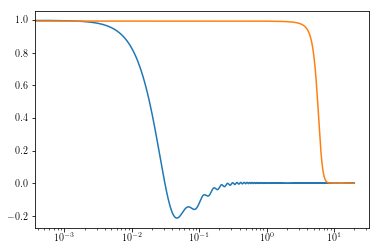

In [13]:
plt.semilogx(t[0],np.real(t[1]))
plt.semilogx(w,F)